# Master's Thesis Experiments Report

In [57]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scripts.utils import load_latency_data

In [44]:
# constants
LAST_FRAME = 526
FIG_DIR = './figures/{}'

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [45]:
fig_dir = FIG_DIR.format('8Mbps')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [46]:
# Load the data
df_conversion = load_latency_data(max_frame=LAST_FRAME - 1)
df_roi = load_latency_data(pipeline='roi', max_frame=LAST_FRAME - 1)
df_dm1 = load_latency_data(pipeline='dm1', max_frame=LAST_FRAME - 1)
df_dm2 = load_latency_data(pipeline='dm2', max_frame=LAST_FRAME - 1)
df_bev = load_latency_data(pipeline='bev', max_frame=LAST_FRAME - 1)
df_max = load_latency_data(pipeline='max', max_frame=LAST_FRAME - 1)

### Filter and Arithmetic Processing Elements

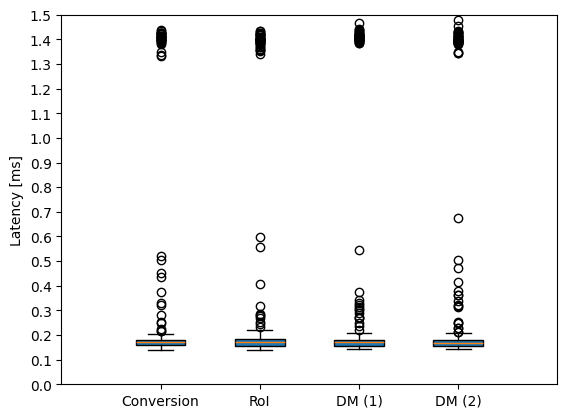

Mean Latency [ms]
Conversion 	 0.2667936893203883
RoI 		 0.264827519379845
DM (1) 		 0.2655542635658915
DM (2) 		 0.2655988372093023


In [47]:
# computation time: conversion vs. RoI vs. DepthMap
fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['CONV'])
ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['RoI'])
ax.boxplot(df_dm1['latency [ms]'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['DM (1)'])
ax.boxplot(df_dm2['latency [ms]'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['DM (2)'])
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 1.5), yticks=[i / 10 for i in range(16)], ylabel='Latency [ms]')
plt.show()
print('Mean Latency [ms]')
print('Conversion \t', df_conversion.mean()['latency [ms]'])
print('RoI \t\t', df_roi.mean()['latency [ms]'])
print('DM (1) \t\t', df_dm1.mean()['latency [ms]'])
print('DM (2) \t\t', df_dm2.mean()['latency [ms]'])
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm.png'))

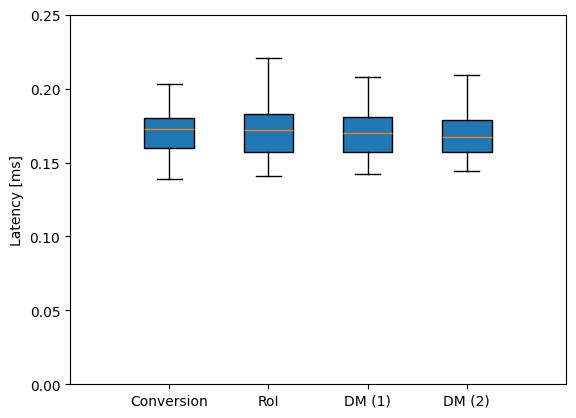

In [48]:
# computation time: conversion vs. RoI vs. DepthMap
fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, tick_labels=['CONV'])
ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, tick_labels=['RoI'])
ax.boxplot(df_dm1['latency [ms]'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, tick_labels=['DM (1)'])
ax.boxplot(df_dm2['latency [ms]'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, tick_labels=['DM (2)'])
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 0.25), yticks=[i / 20 for i in range(6)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm_no_outliers.png'))


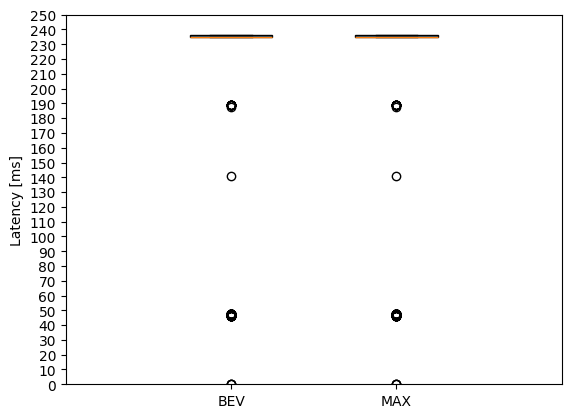

Mean Latency [ms]
BEV 		 211.70197142857143
MAX 		 211.6989295238095


In [49]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['BEV'])
ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, tick_labels=['MAX'])
ax.set(xlim=(0, 6))
ax.set(ylim=(0, 250), yticks=[i * 10 for i in range(26)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'bev_max.png'))

print('Mean Latency [ms]')
print('BEV \t\t', df_bev.mean()['latency [ms]'])
print('MAX \t\t', df_max.mean()['latency [ms]'])

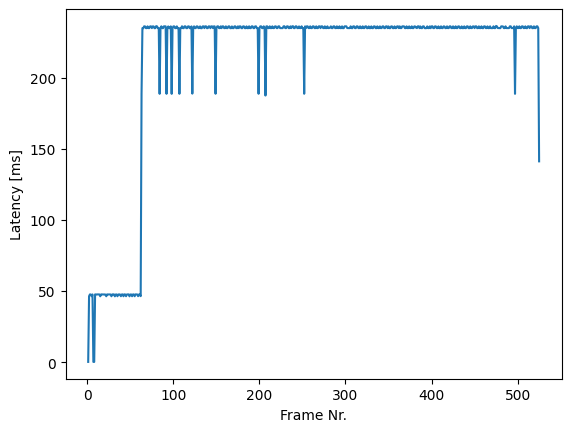

In [60]:
# Evolution of BEV Latency over time
x = [i for i in range(1, LAST_FRAME)]
y = df_bev['latency [ms]']
plt.plot(x, y)
plt.xlabel('Frame Nr.')
plt.ylabel('Latency [ms]')
# plt.title('Evolution of BEV Latency')
plt.show()

In [59]:
first_partition = df_bev.loc[df_bev['frame_nr'] <= 62]
second_partition = df_bev.loc[df_bev['frame_nr'] > 62]
print('Mean Latency [ms]')
print('Frames 1 - 62\t', first_partition.mean()['latency [ms]'])
print('Frames 63 - 525\t', second_partition.mean()['latency [ms]'])

Mean Latency [ms]
Frames 1 - 62	 44.99285483870969
Frames 63 - 525	 234.0258704103672


## 2. Point Rate

In [51]:
# 8 Mbps
num_frames = [['8 Mbps',
               df_conversion.max()['frame_nr'],
               df_roi.max()['frame_nr'],
               df_dm1.max()['frame_nr'],
               df_dm2.max()['frame_nr'],
               df_bev.max()['frame_nr'],
               df_max.max()['frame_nr']]]
for throughput in ['16Mbps', '32Mbps', '64Mbps', '128Mbps']:
    df_conversion = load_latency_data(throughput=throughput, max_frame=LAST_FRAME - 1)
    df_roi = load_latency_data(throughput=throughput, pipeline='roi', max_frame=LAST_FRAME - 1)
    df_dm1 = load_latency_data(throughput=throughput, pipeline='dm1', max_frame=LAST_FRAME - 1)
    df_dm2 = load_latency_data(throughput=throughput, pipeline='dm2', max_frame=LAST_FRAME - 1)
    df_bev = load_latency_data(throughput=throughput, pipeline='bev', max_frame=LAST_FRAME - 1)
    df_max = load_latency_data(throughput=throughput, pipeline='max', max_frame=LAST_FRAME - 1)
    num_frames.append([throughput,
                       df_conversion.max()['frame_nr'],
                       df_roi.max()['frame_nr'],
                       df_dm1.max()['frame_nr'],
                       df_dm2.max()['frame_nr'],
                       df_bev.max()['frame_nr'],
                       df_max.max()['frame_nr']])

df_res = pd.DataFrame(np.array(num_frames), columns=['CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV', 'MAX'])
print(df_res.head(5))